#Persistant Random Walks

 A persistant random walk is a type of correlated random walk, where successive steps in the random walk are positively correlated. 
 

## 1D Persistant Random Walk

Here we consider a random walk which will change its direction of propagation with probability $\beta$ and keep travelling in the same direction with probability $\alpha$.  If $\alpha\neq\beta\neq0.5$ and $\alpha>\beta$ then we have 'persistant random walk', meaning there is a persistance in keepin the same direction. We consider a discrete peristant random walk with time step $\tau$ and step variance $\sigma$.  

## Persistance time
We assume a persistance of $P$ , which means that the 'persistance' of the random walker to maintain the same direction will last for a time $P\tau$ ( $\tau$ is the time step)  . This is called the Persistance Time, $\tau_P$. In other words, at each time step the random walker will change its direction with a probability $\beta=\frac{\tau}{P\tau}=\frac{1}{P}$ and keep the same direction with probability $\alpha=1-\beta=\frac{P-1}{P}.$


##Telegrapher's Equation

The probability distribution of a random walker $p(x,t)$, undergoing persistant random walk is given by the Telegrapher's Equation as,

$$p_{tt}+\frac{1}{P \tau} p_{t} = c^2 p_{xx}$$

where $c$ is the velocity of the persistent random walker

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import special
import tensorflow as tf

sys.path.append('../src/deepymod/')

from scipy.io import loadmat
from DeepMoD import DeepMoD
from library_functions import library_2Din_1Dout
from deepymod.utilities import library_matrix_mat, print_PDE

plt.style.use('ggplot')

In [3]:
N = 10**6      #Number of time steps
dt = 0.01      #Time Step
c =  2         #Velocity
P = 17         #Persistance
P_t = P*dt     #Persistance Time
D = 0.02       #Diffusion constant for noise

t = np.arange(0,N*dt,dt)

In [4]:
def switch(sign):
  if sign<0:
    z=1
  else:
    z=-1
  return z    

We add a bit of white noise at each step to make the step size at each time point a variable. Otherwise we will get nasty Delta function like waves in our distributions at initial time points.

In [5]:
pos_x = np.zeros(N)
pos_x[0]=0
pos_x[1]=np.sqrt(2*D*dt)*np.random.randn(1)
sign = 1
if pos_x[1]-pos_x[0]<0:
  sign = -1

for j in range(2,N):
  
  r = np.random.uniform(0,1)
  
  if r < dt/P_t:
    sign = switch(sign)
  else:
    sign = sign
    
  pos_x[j]=pos_x[j-1]+np.sqrt(2*D*dt)*np.random.randn(1)+sign*c*dt
  

Text(0.5, 1.0, 'Peristant Random Walk Trajectory in 1D')

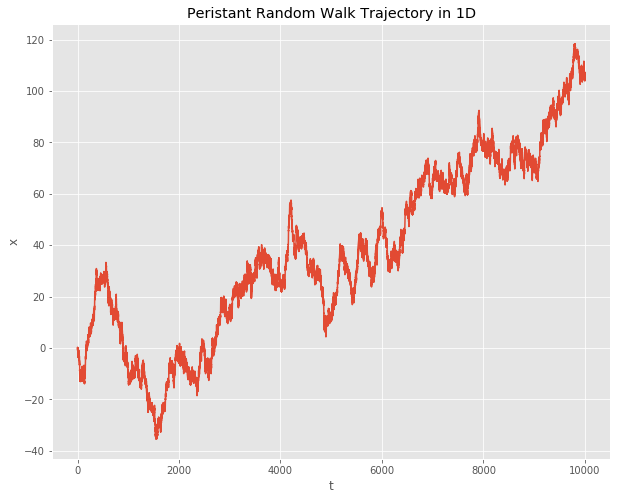

In [6]:
plt.figure(figsize=(10,8))
plt.plot(t,pos_x)
plt.ylabel('x')
plt.xlabel('t')
plt.title('Peristant Random Walk Trajectory in 1D')

##Getting the Distributions

We need to set the number of timepoints where we want to obtain a distribution $m$ and the number of bins in each distribution, $n$. Selecting a suitable $n$ is crucial because choosing an $n$ that is too low will compromise the resolution of the data set and choosing an $n$ that is too high will lead to overfitting.

In [7]:
pos=pos_x
P = {}
M = 0

m = 40    # No of timepoints we want to get the distribution for
n = 275   # No of bins in each distribution

for i in range(m):
    P[i] = []
    
for i in range(len(pos)-m):
    # center
    y = pos[i+1:i+m+1] - pos[i]
    M = max([M, max(abs(y))])
   
    # add to distribution
    for j in range(m):
        P[j].append(y[j])

In [8]:
bins = np.linspace(-M,M,n+1)
x = np.linspace(M*(1/n-1),M*(1-1/n),n)
dx = x[2]-x[1]
T = np.linspace(0,dt*(m-1),m)

U = np.zeros((n,m))

In [9]:
for i in range(m):
    U[:,i] = np.histogram(P[i],bins,)[0]/float(dx*(len(pos)-m))

##Visualizing the data

From the distributions we see that initially there are two travelling wave peaks that move away from the origin. These represent particles that do not change their direction. This behaviour is seen in the timescale $t < P\tau$. 
As more time elapses, eventually all the particles change their directions and the peaks disappear and we see a Diffusive behaviour. This is evident in the distributions of the 

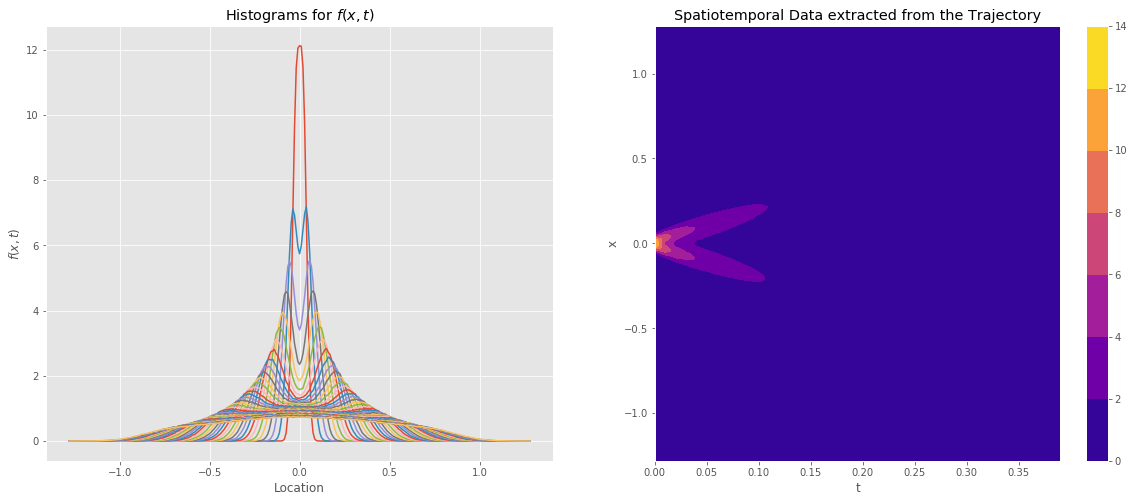

In [10]:
plt.figure(figsize=(20,8))

plt.subplot(121)
for j in range(m):
  plt.plot(x,U[:,j],label ='t = %.2f'%(j*dt+dt))

plt.xlabel('Location')
plt.ylabel(r'$f(x,t)$')
plt.title(r'Histograms for $f(x,t)$')
#plt.legend(loc = 'upper right')

x_grid, t_grid = np.meshgrid(x, T, indexing='ij')

plt.subplot(122)
plt.contourf(T,x,U,cmap='plasma')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Spatiotemporal Data extracted from the Trajectory')
plt.show()

We truncate the data set and get rid of the initial high peaks so that magnitude range of the entire dataset is similar. This will also help represent both the wavelike nature and the diffusive nature of the data set in an unbiased manner.

In [11]:
x_trunc = x[22:-22]
T_trunc = T[12:-1]
U_trunc = U[22:-22,12:-1]

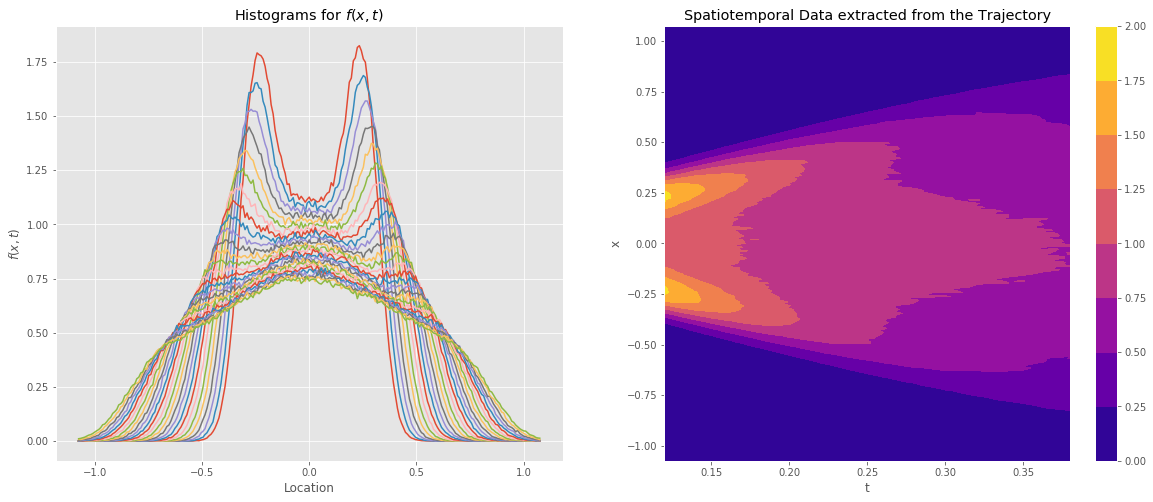

In [12]:
plt.figure(figsize=(20,8))

plt.subplot(121)
for j in range(T_trunc.size):
  plt.plot(x_trunc,U_trunc[:,j],label ='t = %.2f'%(j*dt+dt))

plt.xlabel('Location')
plt.ylabel(r'$f(x,t)$')
plt.title(r'Histograms for $f(x,t)$')
#plt.legend(loc = 'upper right')

x_grid, t_grid = np.meshgrid(x_trunc, T_trunc, indexing='ij')

plt.subplot(122)
plt.contourf(T_trunc,x_trunc,U_trunc,cmap='plasma')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Spatiotemporal Data extracted from the Trajectory')
plt.show()

In [13]:
X = np.transpose((x_grid.flatten(), t_grid.flatten()))
y = U_trunc.reshape((U_trunc.size, 1))

In [14]:
idx = np.random.choice(y.size, y.size)
split = [int(y.size)]

X_train, X_test = np.vsplit(X[idx, :], split)
y_train, y_test = np.vsplit(y[idx, :], split)

In [15]:
print("Number of data points being used -", y_train.size )

Number of data points being used - 6237


In [16]:
u = ['1', 'u', 'uˆ2']
du = ['1', 'u_{t}', 'u_{x}', 'u_{xx}','u_{xxx}']
coeffs_list = library_matrix_mat(u, du)

print(coeffs_list)

library_config = {'total_terms': len(coeffs_list), 'deriv_order': 3, 'poly_order': 2}

['1', 'u_{t}', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u', 'uu_{t}', 'uu_{x}', 'uu_{xx}', 'uu_{xxx}', 'uˆ2', 'uˆ2u_{t}', 'uˆ2u_{x}', 'uˆ2u_{xx}', 'uˆ2u_{xxx}']


In [17]:
def library_1D(data, prediction, library_config):
    '''
    Constructs a library graph in 1D. Library config is dictionary with required terms.
    '''

    # Polynomial
    u = tf.ones_like(prediction)

    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction), axis=1)
    u = tf.expand_dims(u, axis=2)

    # Gradients
    dy = tf.gradients(prediction, data)[0]
    y_t = dy[:, 1:2]
    y_x = dy[:, 0:1]
    
    dtt = tf.gradients(y_t,data)[0]
    
    y_tt = dtt[:, 1:2]
    
    dyy = tf.gradients(y_x, data)[0]
    
    y_xx = dyy[:, 0:1]
    
    dyyy = tf.gradients(y_xx, data)[0]
    
    y_xxx = dyyy[:, 0:1]
    

    du = tf.concat((tf.ones_like(y_t), y_t, y_x, y_xx, y_xxx), axis=1)
    
    
    #for order in np.arange(2, library_config['deriv_order']+1):
    #    du = tf.concat((du, tf.gradients(du[:, order-1], data)[0][:, 0:1]), axis=1)
    du = tf.expand_dims(du, axis=1)

    # Bringing it together
    theta = tf.matmul(u, du)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    return [y_tt], theta

In [20]:
n = 20
config = {'layers': [2, n, n, n, n, 1], 'lambda': 10e-6}
train_opts = {'max_iterations': 200000, 'grad_tol':10**-6, 'learning_rate': 0.004, 'beta1': 0.99, 'beta2': 0.999, 'epsilon': 10**-8}
output_opts = {'output_directory': 'output/PRW/', 'X_predict': X}

In [21]:
sparse_vectors = DeepMoD(X_train, y_train, config, library_1D, library_config, train_opts,output_opts)

Epoch | Total loss | Loss gradient | MSE | PI | L1 
0 [0.83840805, 0.021531215, 0.38808668, 0.45018467, 0.00013666044]
500 [0.16081466, 0.008895043, 0.15857385, 0.0021872472, 5.3559346e-05]
1000 [0.041920833, 0.0026214987, 0.04007254, 0.0016695828, 0.0001787088]
1500 [0.031298526, 0.0018254613, 0.029875165, 0.0012854785, 0.00013788148]
2000 [0.01799628, 0.003609203, 0.017331341, 0.0006224947, 4.244321e-05]


KeyboardInterrupt: 

In [23]:
print_PDE(sparse_vectors[0],coeffs_list,PDE_term='u_tt')

u_tt = 9.529u_{t} + 3.237u_{xx}


##Issues encountered.
1. The coefficient of $u_{tt}$ is found to be positive when it should be negative. It is interesting to note that in the first iteration a negative value is found.

In [ ]:
def PINN_graph(config, library_function, library_config):
    tf.reset_default_graph()
    # Creating datasets
    with tf.name_scope("Defining_variables"):
        data_feed = tf.placeholder(tf.float32, shape=[None, config['layers'][0]])
        target_feed = tf.placeholder(tf.float32, shape=[None, config['layers'][-1]])
        mask_feed = tf.placeholder(tf.int32, shape=[None, config['layers'][-1]])

        lambda_L1 = tf.constant(config['lambda'], tf.float32)

        coeff_list = [tf.Variable(config['initial_coeffs'][output_neuron], dtype=tf.float32) for output_neuron in np.arange(config['layers'][-1])]

    with tf.name_scope("Data_pipeline"):
        mask = tf.ones([tf.size(target_feed[:, 0:1]), tf.shape(mask_feed)[0], tf.shape(mask_feed)[1]], dtype=tf.int32) * tf.expand_dims(mask_feed, axis=0)

        dataset = tf.data.Dataset.from_tensor_slices((data_feed, target_feed, mask)).repeat().batch(tf.shape(data_feed, out_type=tf.int64)[0])

        iterator = dataset.make_initializable_iterator()
        data, target, sparsity_mask = iterator.get_next()

    # The actual network
    with tf.name_scope("Neural_Network"):
        X = data
        for layer in np.arange(len(config['layers'])-2):
            X = tf.layers.dense(X, units=config['layers'][layer+1], activation=tf.nn.tanh, kernel_initializer=tf.constant_initializer(config['initial_weights'][layer]), bias_initializer=tf.constant_initializer(config['initial_biases'][layer]))
        prediction = tf.layers.dense(inputs=X, units=config['layers'][-1], activation=None, kernel_initializer=tf.constant_initializer(config['initial_weights'][-1]), bias_initializer=tf.constant_initializer(config['initial_biases'][-1]))

    # make library according to supplied function
    with tf.name_scope("Creating_library"):
        time_deriv_list, theta = library_function(data, prediction, library_config)
        theta_split = [tf.dynamic_partition(theta, coeff_mask, 2)[1] for coeff_mask in tf.unstack(sparsity_mask, axis=2, num=len(coeff_list))]
        sparse_thetas_list = [tf.reshape(sparse_theta, [tf.shape(theta)[0], tf.size(coeff)]) for coeff, sparse_theta in zip(coeff_list, theta_split)]

    # Normalizing
    with tf.name_scope("Scaling"):
        scaling_time = [tf.norm(time_deriv, axis=0) for time_deriv in time_deriv_list]
        scaling_theta = [tf.expand_dims(tf.norm(sparse_theta, axis=0), axis=1) for sparse_theta in sparse_thetas_list]
        coeff_scaled_list = [coeff * (theta_scale / time_scale) for coeff, theta_scale, time_scale in zip(coeff_list, scaling_theta, scaling_time)]

    # Defining cost function
    with tf.name_scope("Cost_MSE"):
        MSE_costs = tf.reduce_mean(tf.square(target - prediction), axis=0)
        cost_MSE = tf.reduce_mean(MSE_costs)

    with tf.name_scope("Cost_PI"):
        PI_costs = [tf.reduce_mean(tf.square(tf.matmul(sparse_theta, coeff) - time_deriv)) for sparse_theta, coeff, time_deriv in zip(sparse_thetas_list, coeff_list, time_deriv_list)]
        cost_PI = tf.reduce_sum(PI_costs)

    with tf.name_scope('Cost_L1'):
        L1_costs = [lambda_L1 * tf.reduce_sum(tf.abs(coeff[1:, :])) for coeff in coeff_scaled_list]
        cost_L1 = tf.reduce_sum(L1_costs)

    with tf.name_scope("Total_cost"):
        loss = cost_MSE + cost_PI + cost_L1

    # graph node for gradient
    with tf.name_scope("GradLoss"):
        grad_losses = [tf.reduce_max(tf.abs(tf.gradients(loss, coeff)[0]) / (theta_scale / time_scale)) for coeff, theta_scale, time_scale in zip(coeff_list, scaling_theta, scaling_time)]
        gradloss = tf.reduce_max(grad_losses)

    return AttrDict(locals())

def inference_graph(data, weights, biases, layers, batchsize=1000):
    dataset = tf.data.Dataset.from_tensor_slices(data).batch(batchsize)
    iterator = dataset.make_one_shot_iterator()
    data = iterator.get_next()

    X = data
    for layer in np.arange(len(layers)-2):
        X = tf.layers.dense(X, units=layers[layer+1], activation=tf.nn.tanh, kernel_initializer=tf.constant_initializer(weights[layer]), bias_initializer=tf.constant_initializer(biases[layer]))
    prediction = tf.layers.dense(inputs=X, units=layers[-1], activation=None, kernel_initializer=tf.constant_initializer(weights[-1]), bias_initializer=tf.constant_initializer(biases[-1]))

    return AttrDict(locals())

class AttrDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [ ]:
def PINN(data, target, mask, config, library_function, library_config, train_opts):
    # Defining graph, optimizer and feed_dict
    graph = PINN_graph(config, library_function, library_config)

    train_op = tf.train.AdamOptimizer(learning_rate=train_opts['learning_rate'], beta1=train_opts['beta1'], beta2=train_opts['beta2'], epsilon=train_opts['epsilon']).minimize(graph.loss)

    feed_dict = {graph.data_feed: data, graph.target_feed: target, graph.mask_feed: mask}

    # Running the fitting procedure
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer(), feed_dict=feed_dict)
        sess.run(graph.iterator.initializer, feed_dict=feed_dict)

        #writer = tf.summary.FileWriter(os.path.join(output_opts['output_directory'], "iteration_" + str(output_opts['cycles'])))
        #writer.add_graph(sess.graph)
        #merged_summary, custom_board = tb_setup(graph, output_opts)
        #writer.add_summary(custom_board)

        print('Epoch | Total loss | Loss gradient | MSE | PI | L1 ')
        for iteration in np.arange(train_opts['max_iterations']):
            sess.run(train_op)
            #if iteration % 50 == 0:
            #    summary = sess.run(merged_summary)
            #    writer.add_summary(summary, iteration)
            if iteration % 500 == 0:
                print(iteration, sess.run([graph.loss, graph.gradloss, graph.cost_MSE, graph.cost_PI, graph.cost_L1]))
                if sess.run(graph.gradloss) < train_opts['grad_tol']:
                    print('Optimizer converged.')
                    break
          

        coeff_list = [map_to_sparse_vector(coeff_mask, coeff) for coeff_mask, coeff in zip(np.split(mask, mask.shape[1], axis=1), sess.run(graph.coeff_list))]
        coeff_scaled_list = [map_to_sparse_vector(coeff_mask, coeff) for coeff_mask, coeff in zip(np.split(mask, mask.shape[1], axis=1), sess.run(graph.coeff_scaled_list))]

        weights_biases = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))[len(coeff_list):]
        weights = weights_biases[::2]
        biases = weights_biases[1::2]

    return coeff_list, coeff_scaled_list, weights, biases

def inference(data, weights, biases, layers, batchsize=1000):
    graph = inference_graph(data, weights, biases, layers, batchsize=batchsize)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        prediction = [sess.run(graph.prediction) for batch in np.arange(np.ceil(data.shape[0]/batchsize))]
        prediction = np.concatenate(prediction, axis=0)

    return prediction


def map_to_sparse_vector(mask, coeff):
    sparse_vec = np.zeros_like(mask, dtype=np.float)
    sparse_vec[np.where(mask)[0]] = coeff

    return sparse_vec

In [ ]:


'''
This file contains several ready-to-use library functions.
'''

def library_1D(data, prediction, library_config):
    '''
    Constructs a library graph in 1D. Library config is dictionary with required terms.
    '''

    # Polynomial
    u = tf.ones_like(prediction)

    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction), axis=1)
    u = tf.expand_dims(u, axis=2)

    # Gradients
    dy = tf.gradients(prediction, data)[0]
    y_t = dy[:, 1:2]
    y_x = dy[:, 0:1]
    
    dtt = tf.gradients(y_t,data)[0]
    
    y_tt = dtt[:, 1:2]
    
    dyy = tf.gradients(y_x, data)[0]
    
    y_xx = dyy[:, 0:1]
    
    dyyy = tf.gradients(y_xx, data)[0]
    
    y_xxx = dyyy[:, 0:1]
    

    du = tf.concat((tf.ones_like(y_t), y_t, y_x, y_xx, y_xxx), axis=1)
    
    
    #for order in np.arange(2, library_config['deriv_order']+1):
    #    du = tf.concat((du, tf.gradients(du[:, order-1], data)[0][:, 0:1]), axis=1)
    du = tf.expand_dims(du, axis=1)

    # Bringing it together
    theta = tf.matmul(u, du)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    return [y_tt], theta

def library_2Din_1Dout(data, prediction, library_config):
        '''
        Constructs a library graph in 1D. Library config is dictionary with required terms.
        '''

        # Polynomial
        u = tf.ones_like(prediction)

        for order in np.arange(1, library_config['poly_order']+1):
            u = tf.concat((u, u[:, order-1:order]*prediction), axis=1)
        u = tf.expand_dims(u, axis=2)

        # Gradients
        du = tf.gradients(prediction, data)[0]
        u_t = du[:, 0:1]
        u_x = du[:, 1:2]
        u_y = du[:, 2:3]
        du2 = tf.gradients(u_x,data)[0]
        u_xx = du2[:, 1:2]
        u_xy = du2[:, 2:3]
        u_yy = tf.gradients(u_y,data)[0][:, 2:3]
        du = tf.concat((tf.ones_like(u_x), u_x, u_y , u_xx, u_yy, u_xy), axis=1)
        #for order in np.arange(2, library_config['deriv_order']+1):
        #    du = tf.concat((du, tf.gradients(du[:, order-1], data)[0][:, 0:1]), axis=1)
        du = tf.expand_dims(du, axis=1)

        # Bringing it together
        theta = tf.matmul(u, du)
        theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

        return [u_t], theta


def library_2Din_2Dout(data, prediction, library_config):

    #Polynomial in u
    u = tf.ones_like(prediction[:, 0:1])

    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction[:, 0:1]), axis=1)
    u = tf.expand_dims(u, axis=2)

    print(u.shape)

    # Polynomial in v
    v = tf.ones_like(prediction[:, 1:2])

    for order in np.arange(1, library_config['poly_order']+1):
        v = tf.concat((v, v[:, order-1:order]*prediction[:, 1:2]), axis=1)
    v = tf.expand_dims(v, axis=1)

    print(v.shape)
    # Calculating all cross terms
    uv = tf.matmul(u, v)
    uv = tf.reshape(uv, [tf.shape(u)[0], tf.size(uv[0, :, :])])
    uv = tf.expand_dims(uv,axis=2)


    print(uv.shape)
    # Derivative in u
    du = tf.gradients(prediction[:, 0:1], data)[0]
    u_t = du[:, 0:1]
    u_x = du[:, 1:2]
    u_y = du[:, 2:3]
    du2 = tf.gradients(u_x, data)[0]
    u_xx = du2[:, 1:2]
    u_xy = du2[:, 2:3]
    u_yy = tf.gradients(u_y, data)[0][:, 2:3]
    du = tf.concat((u_x, u_y , u_xx, u_yy, u_xy), axis=1)
    print(du.shape)
    # Derivative in v
    dv = tf.gradients(prediction[:, 1:2], data)[0]
    v_t = dv[:, 0:1]
    v_x = dv[:, 1:2]
    v_y = dv[:, 2:3]
    dv2 = tf.gradients(v_x, data)[0]
    v_xx = dv2[:, 1:2]
    v_xy = dv2[:, 2:3]
    v_yy = tf.gradients(v_y,data)[0][:, 2:3]
    dv = tf.concat((v_x, v_y , v_xx, v_yy, v_xy), axis=1)
    print(dv.shape)
    # Bringing du and dv together and calculating cross terms
    dudv = tf.concat((tf.ones_like(v_x), du, dv), axis=1)
    dudv = tf.expand_dims(dudv, axis=1)
    theta = tf.matmul(uv, dudv)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    time_deriv = [u_t, v_t]

    return time_deriv, theta

def library_2Din_2Dout_lim(data, prediction, library_config):

    #Polynomial in u
    u = tf.ones_like(prediction[:, 0:1])

    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction[:, 0:1]), axis=1)
    u = tf.expand_dims(u, axis=2)


    # Polynomial in v
    v = tf.ones_like(prediction[:, 1:2])

    for order in np.arange(1, library_config['poly_order']+1):
        v = tf.concat((v, v[:, order-1:order]*prediction[:, 1:2]), axis=1)
    v = tf.expand_dims(v, axis=1)


    # Calculating all cross terms
    uv = tf.matmul(u, v)
    uv = tf.reshape(uv, [tf.shape(u)[0], tf.size(uv[0, :, :])])
    uv = tf.expand_dims(uv,axis=2)

    # Derivative in u
    du = tf.gradients(prediction[:, 0:1], data)[0]
    u_t = du[:, 0:1]
    u_x = du[:, 1:2]
    u_y = du[:, 2:3]
    du2 = tf.gradients(u_x, data)[0]
    u_xx = du2[:, 1:2]
    u_yy = tf.gradients(u_y, data)[0][:, 2:3]
    du = tf.concat((u_xx, u_yy), axis=1)

    # Derivative in v
    dv = tf.gradients(prediction[:, 1:2], data)[0]
    v_t = dv[:, 0:1]
    v_x = dv[:, 1:2]
    v_y = dv[:, 2:3]
    dv2 = tf.gradients(v_x, data)[0]
    v_xx = dv2[:, 1:2]
    v_yy = tf.gradients(v_y,data)[0][:, 2:3]
    dv = tf.concat((v_xx, v_yy), axis=1)

    # Bringing du and dv together and calculating cross terms
    dudv = tf.concat((tf.ones_like(v_x), du, dv), axis=1)
    dudv = tf.expand_dims(dudv, axis=1)
    theta = tf.matmul(uv, dudv)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    time_deriv = [u_t, v_t]

    return time_deriv, theta

def library_1Din_2Dout_chemo(data, prediction, library_config):
    #Polynomial in u
    
    u = tf.ones_like(prediction[:, 0:1])
    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction[:, 0:1]), axis=1)
    u = tf.expand_dims(u, axis=2)

    print("u",u.shape)
    
    # Polynomial in v
    
    v = tf.ones_like(prediction[:, 1:2])
    for order in np.arange(1, library_config['poly_order']+1):
        v = tf.concat((v, v[:, order-1:order]*prediction[:, 1:2]), axis=1)
    v = tf.expand_dims(v, axis=1)

    print("v",v.shape)      
    
    # Derivative in u
    du = tf.gradients(prediction[:, 0:1], data)[0]
    u_t = du[:, 1:2]
    u_x = du[:, 0:1]
    
    du2 = tf.gradients(u_x, data)[0]
    u_xx = du2[:, 0:1]

    du = tf.concat((u_x,u_xx),axis=1)
    print("du",du.shape)
    
    # Derivative in v
    dv = tf.gradients(prediction[:, 1:2], data)[0]
    v_t = dv[:, 1:2]
    v_x = dv[:, 0:1]

    dv2 = tf.gradients(v_x, data)[0]
    v_xx = dv2[:, 0:1]
    
    dv=tf.concat((v_x, v_xx),axis=1)
    print("dv",dv.shape)
     
    #Calculating all cross derivative terms
    Du = du
    Dv = dv
    
    Du = tf.expand_dims(Du, axis=2)
    Dv = tf.expand_dims(Dv, axis=1)
    
    Ddudv = tf.matmul(Du,Dv)
    Ddudv = tf.reshape(Ddudv, [tf.shape(Ddudv)[0], tf.size(Ddudv[0, :, :])])
    
    # Calculating all cross terms
    
    uv = tf.matmul(u, v)
    uv = tf.reshape(uv, [tf.shape(u)[0], tf.size(uv[0, :, :])])
    uv = tf.expand_dims(uv,axis=2)

    print("uv",uv.shape)
    print("Ddudv",Ddudv.shape)
    
    # Bringing du and dv together and calculating cross terms
    dudv = tf.concat((tf.ones_like(v_x), du, dv, Ddudv), axis=1)
    
    print("dudv",dudv.shape)
    
    dudv = tf.expand_dims(dudv, axis=1)
    theta = tf.matmul(uv, dudv)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    time_deriv = [u_t, v_t]

    return time_deriv, theta



In [ ]:
def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it,
    mimicking how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list = []
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list


def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx, term in enumerate(non_zero_idx):
        if idx != 0:
            if np.sign(sparse_vector[term]) == -1:
                PDE += ' - '
            else:
                PDE += ' + '
        PDE += '%.3f' % np.abs(sparse_vector[term]) + coeffs_list[term]
    print(PDE)

In [ ]:
def DeepMoD(data, target, config, library_function, library_config, train_opts):
    # Defining internal configuration
    internal_config = copy.deepcopy(config)

    # Defining initial weights, biases and coefficients for the network
    initial_coeffs = [np.random.rand(library_config['total_terms'], 1) * 2 - 1 for output_neuron in np.arange(config['layers'][-1])]
    initial_biases = [np.zeros(neurons) for neurons in config['layers'][1:]]
    initial_weights = [np.random.randn(input_neurons, output_neurons) * np.sqrt(1 / (input_neurons + output_neurons)) for input_neurons, output_neurons in zip(config['layers'][:-1], config['layers'][1:])]  # Xavier initalization


    internal_config.update({'initial_coeffs': initial_coeffs, 'initial_weights': initial_weights, 'initial_biases': initial_biases})

    #output_opts['output_directory'] = os.path.join(output_opts['output_directory'], datetime.now().strftime("%Y%m%d_%H%M%S"))  #making folder with timestamp

    # Run minimization procedure
    mask = np.ones((library_config['total_terms'], config['layers'][-1]))
    #output_opts.update({'cycles': 0})

    coeff_list, coeff_scaled_list, weights, biases = PINN(data, target, mask, internal_config, library_function, library_config, train_opts)
    sparsity_pattern_list = [thresholding(coeff, mode='auto') for coeff in coeff_scaled_list]

    #output_opts['cycles'] += 1

    # Updating everything else for next cycle
    mask[~np.transpose(np.squeeze(np.array(sparsity_pattern_list)))] = 0
    coeff_list_thresholded = [np.expand_dims(coeff[sparsity_pattern], axis=1) for coeff, sparsity_pattern in zip(coeff_list, sparsity_pattern_list)]
    internal_config.update({'initial_coeffs': coeff_list_thresholded, 'initial_weights': weights, 'initial_biases': biases})

    # Printing current sparse vector to see progress
    print('Current sparse vectors:')
    print([map_to_sparse_vector(sparsity_pattern, coeff) for sparsity_pattern, coeff in zip(sparsity_pattern_list, coeff_list_thresholded)])

    # Now thats it's converged, fit again but without the L1 penalty
    print('Now running for the final time...')
    internal_config['lambda'] = 0
    coeff_list, _, weights, biases = PINN(data, target, mask, internal_config, library_function, library_config, train_opts)

    #if 'X_predict' in output_opts.keys():
    #    prediction = inference(output_opts['X_predict'], weights, biases, internal_config['layers'])
    #    return coeff_list, prediction
    #else:
    #   return coeff_list
      
    return coeff_list


def thresholding(vector, mode, treshold=0.0):
    if mode == 'auto':
        upper_lim, lower_lim = np.median(vector)+np.std(vector), np.median(vector) - np.std(vector)
        sparsity_mask = (vector <= upper_lim) & (vector >= lower_lim)
    else:
        sparsity_mask = np.abs(vector) < treshold

    return ~sparsity_mask